In [1]:
## This is a python port of Dr. Matt Maschmann's Matlab CNT growth simulation code. This script simulates an iterative CNT
#  growth process by introducing new material at each time step and then solving for the finite element interactions (stress
#  and strain of the finite elements are modeled as a beam) between steps. NOTE: THE GLOBAL VARIABLES DEFINED ON LINES 5 AND
#  6 IN MATLAB ARE DEFINED AS LOCAL ONES HERE FOR SIMPLICITY (classes and mods to be introduced to the python script later)
from pathlib import Path
import math
import numpy as np
import time
import scipy
from scipy.sparse import *
from scipy.sparse import coo_matrix, linalg as sla
from scipy import *
import random as rand
from scipy.sparse.linalg import spsolve, bicg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import imageio
import os
from sklearn.neighbors import NearestNeighbors


In [2]:
avgRate=-1
while avgRate < 30 or avgRate > 90:
    try:
        avgRate = float(input("Choose avg growth rate in nm/step (30-60): "))
        if avgRate < 30 or avgRate > 90:
            print("Invalid rate. Please enter a value between 30 and 90.")
    except ValueError:
            print("Invalid input. Please enter a valid number.")
avgRate=avgRate*1e-9

Choose avg growth rate in nm/step (30-60): 32


In [3]:
rate_stdev=-1
while rate_stdev < 1 or rate_stdev > 7:
    try:
        rate_stdev = float(input("Choose standard deviation of growth rate (1-7): "))
        if rate_stdev < 1 or rate_stdev > 7:
            print("Invalid stdDev. Please enter a value between 1 and 7.")
    except ValueError:
            print("Invalid input. Please enter a valid number.")

Choose standard deviation of growth rate (1-7): 6.66777


In [15]:
ang_stdev=-1
while ang_stdev < 1 or ang_stdev > 7:
    try:
        ang_stdev = float(input("Choose standard deviation of growth angle (1-5): "))
        if ang_stdev < 1 or ang_stdev > 5:
            print("Invalid ang_stdev. Please enter a value between 1 and 5.")
    except ValueError:
            print("Invalid input. Please enter a valid number.")

Choose standard deviation of growth angle (1-5): 5


In [6]:
#initialize these variables first - the sizes of initialized arrays are functions of these 3 parameters
span=25e-6 #modeling regime (meters) - want 10 CNT per micron - this way they interact during growth
numberBeams=250 #adjust to fit troubleshooting needs, original is 250 - need to make sure they interact during growth
steps=200  #number of growth steps

##List of all arrays that grow in matlab
meanvdw=np.zeros((steps,1));meanvdwsmall=np.zeros((steps,1))
medianvdw=np.zeros((steps,1));maxvdw=np.zeros((steps,1))
minvdw=np.zeros((steps,1));origin=np.zeros(numberBeams)
ang=np.zeros(numberBeams);rate=np.zeros(numberBeams)
ro=np.zeros(steps*numberBeams);ri=np.zeros(numberBeams)
nodeCoordinates=np.zeros(((steps+2)*numberBeams,2))
nucleationSite=np.zeros((numberBeams,2))
growthNode=np.zeros((numberBeams,2))
elementNodes=np.zeros(((steps+2)*numberBeams,2),dtype=int)
L=np.zeros((steps+1)*numberBeams);A=np.zeros((steps+1)*numberBeams)
E=np.zeros((steps+1)*numberBeams);I=np.zeros((steps+1)*numberBeams)
C=np.zeros(steps*numberBeams);S=np.zeros(steps*numberBeams)

E_0=np.ones(numberBeams)*1E12;rout=5E-9; rin=0.7*rout # Modulus ; outer radius; inner radius
g_mod=1e11; a_cc=math.pi*(rout**2-rin**2) #Shear modulus; cross-sectional area
I_def=math.pi/4*(rout**4-rin**4)
gap=50e-9; gap2=gap**2; A_0=np.ones(numberBeams)*a_cc #note, this 
            #does not support unique CNT radii

In [7]:
#windows
#fname=Path("/Users/Gordo/Desktop/CNT/Images/Junk/") # NOTE: Currently, files are saved to this directory
#ubuntu
fname=os.path.join(os.path.expanduser('~'),'Documents', 'CNT', 'Images', 'Junk')

title='Test' #These lines set up image names
name=title
title2=name+'_Float3'


#avgRate=60e-9 # Average growth per time step (meters)
#rate_stdev=4 #growth rate standard deviation
#ang_stdev=3 #growth angle standard deviation


## INPUT SETTINGS - should we use boolean data types in python?
computeVDW=0 # compute vdW forces? 0=  no
ContinuousPlot=0 # 0=plotting off.  1=plotting on
PeriodicBoundary=1 # 0=off, 1=on
beamType=0 # 0=Euler Beam ; 1=Timoshenko Beam
totalCompress=0 # if using compression
compressiveLoad=0 # if using compression
element=numberBeams # sets the number of elements = number of CNTs
nodeCount=2*numberBeams # initial number of evaluation nodes

In [8]:
## Define nucleate_Uniform function
def nucleate_Uniform(numberBeams,span,avgRate,rout,rin,rate_stdev,ang_stdev,E):
    
    for o in range(numberBeams):
        origin[o]=span/(numberBeams)*(o+1/2);##+span/(numberBeams-1)*rand()
    
   
    
    rand.seed() #Re-seed random number generator
    
    ## Here we nucleate the rates of the beams

    for ii in range(numberBeams): ## 1/3 of the beams will grow more slowly
        mu_ang=math.pi/2
        Sigma_ang=np.atleast_2d((ang_stdev*math.pi/180)**2)
        R_ang=np.linalg.cholesky(Sigma_ang)
        ang[ii]=mu_ang+np.random.normal()*R_ang

        rand.seed()
        mu_rate=avgRate
        Sigma_rate=np.atleast_2d((rate_stdev/100*avgRate)**2)
        R_rate=np.linalg.cholesky(Sigma_rate)
        rate[ii]=mu_rate+np.random.normal()*R_rate
    
        ro[ii]=rout
        ri[ii]=rin
        I[ii]= (math.pi/4)*(rout**4-rin**4)
        
    E=E #recyle the initial E - an array defining the 

    nodeCount=0
    element=0
    
    for num in range(numberBeams,2*numberBeams): ## Assign bottom coordinates to first generation of CNTs
        nodeCount=nodeCount+1
        nodeCoordinates[num,0]=origin[num-numberBeams]  ##defines the x-location of nucleation.
        nodeCoordinates[num,1]=0
    
        nucleationSite[num-numberBeams,0]=nodeCoordinates[num,0] ##xx(num)
        nucleationSite[num-numberBeams,1]=nodeCoordinates[num,1] ##yy(num)
    
    for num in range(numberBeams): ##Setting position of CNT free ends (top nodes)
        nodeCount=nodeCount+1
        nodeCoordinates[num,0]=nodeCoordinates[num+numberBeams,0]+math.cos(ang[num])*rate[num]
        nodeCoordinates[num,1]=nodeCoordinates[num+numberBeams,1]+math.sin(ang[num])*rate[num]
       
        growthNode[num,0]=nodeCoordinates[num,0]
        growthNode[num,1]=nodeCoordinates[num,1]
        
        elementNodes[element,0]=element
        elementNodes[element,1]=nodeCount-1
        element=element+1
        

    return [elementNodes,ang,rate,nodeCoordinates,nodeCount,element,nucleationSite,growthNode,ro,ri,E,I]

In [9]:
def StiffnessPartial(E,A,I,L,C,S,G,element,elementNodes,GDof,beamType,totalDOFs):

    ## In the 2D stiffness matrix, there are 6 unique entries. They are
    #  labeled as w1... w6 here.

    alpha=1 # this has never been activated...
    if beamType==0:
        epsilon=0
    else:
        epsilon=(12*alpha/g_mod)*np.multiply(E,np.divide(I,A,out=np.zeros_like(A),where=A!=0))

        
    #Ni and Nj are indices that take element nodes and assigns each node an
    #appropriate location within the stiffness matrix, K

    Ni=np.atleast_2d(3*(elementNodes[:A.shape[0],0])-1)
    Nj=np.atleast_2d(3*(elementNodes[:A.shape[0],1])-1)
    
    #Each element will have 36 entries into a stiffness matrix. ii_local and
    #jj_local are the indices associated with each of the 36 entries. This step
    #was taken for vectorization
    ii_local=np.concatenate((Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3),axis=0)
    jj_local=np.concatenate((Ni+1,Ni+1,Ni+1,Ni+1,Ni+1,Ni+1,Ni+2,Ni+2,Ni+2,Ni+2,Ni+2,Ni+2,Ni+3,Ni+3,Ni+3,Ni+3,Ni+3,Ni+3,Nj+1,Nj+1,Nj+1,Nj+1,Nj+1,Nj+1,Nj+2,Nj+2,Nj+2,Nj+2,Nj+2,Nj+2,Nj+3,Nj+3,Nj+3,Nj+3,Nj+3,Nj+3),axis=0)
    
    #multiply arrays first
    E_L=np.divide(E,L,out=np.zeros_like(L),where=L!=0)
    A_C_C=np.multiply(A,np.square(C))
    A_S_S=np.multiply(A,np.square(S))
    I_S_S_12=12*np.multiply(I,np.square(S))
    I_C_C_12=12*np.multiply(I,np.square(C))
    L_L=np.square(L)
    eps_1=np.ones(L.shape)+epsilon
    L_L_eps1=np.multiply(L_L,eps_1)
    S_C=np.multiply(S,C)
    I_S=np.multiply(I,S)
    I_C=np.multiply(I,C)
    I_L_L_eps1=np.divide(I,L_L_eps1,out=np.zeros_like(L_L_eps1),where=L_L_eps1!=0)
    L_eps1=np.multiply(L,eps_1)
    # The six unique stiffness matrix entries are computed below
    w1=np.multiply(E_L,(A_C_C + np.divide(I_S_S_12,L_L_eps1,out=np.zeros_like(L_L_eps1),where=L_L_eps1!=0)))
    w2=np.multiply(E_L,(A_S_S + np.divide(I_C_C_12,L_L_eps1,out=np.zeros_like(L_L_eps1),where=L_L_eps1!=0)))
    w3=np.multiply(E_L,(np.multiply((A-12*I_L_L_eps1),S_C)))
    w4=np.multiply(E_L,(6.*np.divide(I_S,L_eps1,out=np.zeros_like(L_L_eps1),where=L_L_eps1!=0)))
    w5=np.multiply(E_L,(6.*np.divide(I_C,L_eps1,out=np.zeros_like(L_L_eps1),where=L_L_eps1!=0)))
    
    ## Creates a vectorized set of K matrix entries, Kg. Each element will have 
    # 36 entries. The code below create a vector of 36 entries for each element
    # in the system
    Kg=np.zeros((E.shape[0],36))
    Kg[0:E.shape[0],0]=w1
    Kg[0:E.shape[0],1]=w3
    Kg[0:E.shape[0],2]=-w4
    Kg[0:E.shape[0],3]=-w1
    Kg[0:E.shape[0],4]=-w3
    Kg[0:E.shape[0],5]=-w4
    Kg[0:E.shape[0],6]=w3
    Kg[0:E.shape[0],7]=w2
    Kg[0:E.shape[0],8]=w5
    Kg[0:E.shape[0],9]=-w3
    Kg[0:E.shape[0],10]=-w2
    Kg[0:E.shape[0],11]=w5
    Kg[0:E.shape[0],12]=-w4
    Kg[0:E.shape[0],13]=w5
    Kg[0:E.shape[0],14]=4*np.multiply(I,E_L)
    Kg[0:E.shape[0],15]=w4
    Kg[0:E.shape[0],16]=-w5
    Kg[0:E.shape[0],17]=2*np.multiply(I,E_L)
    Kg[0:E.shape[0],18]=-w1
    Kg[0:E.shape[0],19]=-w3
    Kg[0:E.shape[0],20]=w4
    Kg[0:E.shape[0],21]=w1
    Kg[0:E.shape[0],22]=w3
    Kg[0:E.shape[0],23]=w4
    Kg[0:E.shape[0],24]=-w3
    Kg[0:E.shape[0],25]=-w2
    Kg[0:E.shape[0],26]=-w5
    Kg[0:E.shape[0],27]=w3
    Kg[0:E.shape[0],28]=w2
    Kg[0:E.shape[0],29]=-w5
    Kg[0:E.shape[0],30]=-w4
    Kg[0:E.shape[0],31]=w5
    Kg[0:E.shape[0],32]=2*np.multiply(I,E_L)
    Kg[0:E.shape[0],33]=w4
    Kg[0:E.shape[0],34]=-w5
    Kg[0:E.shape[0],35]=4*np.multiply(I,E_L)
    Kg=np.transpose(Kg)
    
    # Creates a sparse matrix based upon the indices and values created above
    Kg_flat=Kg.flatten()
    ii_flat=ii_local.flatten()
    jj_flat=jj_local.flatten()
    K=coo_matrix((Kg_flat,(ii_flat,jj_flat)),shape=(totalDOFs,totalDOFs)).tocsr()
    # the dimensions are: [row, column, value, sparse matrix n dim, sparse matrix m dim], COO format
    return K

In [10]:
## Define ConnectionStiffness_Partial
def ConnectionStiffness_Partial(E,rout,CC,SS,sizeClose,closeNodes,GDof,beamType,totalDOFs):
#erased unused quantities E, Ac, Ic, LL, G, EI

    ## In the 2D stiffness matrix, there are 6 unique entries. They are
    #  labeled as w1... w6 here.
    vdwk=np.zeros(CC.shape[0])

    alpha=1 # this has never been activated...
    if beamType==0:
        epsilon=0
    else:
        epsilon=0
        print('this has unintended effect')

    #vdwk=E
    if np.any(ro==5e-09):
        vdwk=273*np.ones(vdwk.shape) #Spring stiffness of bar element between CNTs
    elif np.any(ro==12.5e-09):
        vdwk=430*np.ones(vdwk.shape)
    else:
        print('check CNT Radii')

    #Ni and Nj are indices that take element nodes and assigns each node an
    #appropriate location within the stiffness matrix, K

    Ni=np.atleast_2d(3*(closeNodes[:,0])-1)
    Nj=np.atleast_2d(3*(closeNodes[:,1])-1)        
        
    #Each element will have 36 entries into a stiffness matrix. ii_local and
    #jj_local are the indices associated with each of the 36 entries. This step
    #was taken for vectorization
    ii_local=np.concatenate((Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3,Ni+1,Ni+2,Ni+3,Nj+1,Nj+2,Nj+3),axis=0)
    jj_local=np.concatenate((Ni+1,Ni+1,Ni+1,Ni+1,Ni+1,Ni+1,Ni+2,Ni+2,Ni+2,Ni+2,Ni+2,Ni+2,Ni+3,Ni+3,Ni+3,Ni+3,Ni+3,Ni+3,Nj+1,Nj+1,Nj+1,Nj+1,Nj+1,Nj+1,Nj+2,Nj+2,Nj+2,Nj+2,Nj+2,Nj+2,Nj+3,Nj+3,Nj+3,Nj+3,Nj+3,Nj+3),axis=0)

    w1=np.multiply(vdwk,np.square(CC))
    w2=np.multiply(vdwk,np.multiply(SS,CC))    
    w3=np.multiply(vdwk,np.square(SS))

    ## Creates a vectorized set of K matrix entries, Kg. Each element will have 
    # 36 entries. The code below create a vector of 36 entries for each element
    # in the system
    Kg=np.zeros((sizeClose,36))
    Kg[0:sizeClose,0]=w1
    Kg[0:sizeClose,1]=w2
    Kg[0:sizeClose,2]=0
    
    Kg[0:sizeClose,3]=-w1
    Kg[0:sizeClose,4]=-w2
    Kg[0:sizeClose,5]=0
    
    Kg[0:sizeClose,6]=w2
    Kg[0:sizeClose,7]=w3
    Kg[0:sizeClose,8]=0
    
    Kg[0:sizeClose,9]=-w2
    Kg[0:sizeClose,10]=-w3
    Kg[0:sizeClose,11]=0
    
    Kg[0:sizeClose,12]=0
    Kg[0:sizeClose,13]=0
    Kg[0:sizeClose,14]=0
    Kg[0:sizeClose,15]=0
    Kg[0:sizeClose,16]=0
    Kg[0:sizeClose,17]=0
    
    Kg[0:sizeClose,18]=-w1
    Kg[0:sizeClose,19]=-w2
    Kg[0:sizeClose,20]=0
    
    Kg[0:sizeClose,21]=w1
    Kg[0:sizeClose,22]=w2
    Kg[0:sizeClose,23]=0
    
    Kg[0:sizeClose,24]=-w2
    Kg[0:sizeClose,25]=-w3
    Kg[0:sizeClose,26]=0
    
    Kg[0:sizeClose,27]=w2
    Kg[0:sizeClose,28]=w3
    Kg[0:sizeClose,29]=0
    
    Kg[0:sizeClose,30]=0
    Kg[0:sizeClose,31]=0
    Kg[0:sizeClose,32]=0
    Kg[0:sizeClose,33]=0
    Kg[0:sizeClose,34]=0
    Kg[0:sizeClose,35]=0
    
    Kg=np.transpose(Kg)
    
    # Creates a sparse matrix based upon the indices and values created above
    Kg_flat=Kg.flatten()
    ii_flat=ii_local.flatten()
    jj_flat=jj_local.flatten()
    ii_flat[ii_flat<0]=0
    jj_flat[jj_flat<0]=0
    AA=coo_matrix((Kg_flat,(ii_flat,jj_flat)),shape=(totalDOFs,totalDOFs)).tocsr()
    
    return [AA,vdwk]

In [11]:
## Define CNTPlotFast for a fast plotting algorithm
def CNTPlotFast(fname,nodeCoordinates,t,title):
    fig=plt.figure(figsize=(5.0,5.0),dpi=800)
    plt.title('')
    plt.xlabel('Substrate Position (µm)')
    plt.ylabel('Forest Height (µm)')
    plt.xlim((0,span*1e6))
    plt.ylim((0,span*1e6))
    plt.plot(nodeCoordinates[:nodeCount,0]*1e6,nodeCoordinates[:nodeCount,1]*1e6,marker='.',ms=0.0000001,lw=1,color='black',linestyle='None');
    #fname=Path("/Users/Gordo/Desktop/CNT/Images/Junk/"+str(t)) # NOTE: Currently, files are saved to this directory
    fname=os.path.join(os.path.expanduser('~'),'Documents', 'CNT', 'Images', 'Junk')+'/'+str(t) # NOTE: Currently, files are saved to this directory
    #plt.savefig(fname,dpi=800)

In [12]:
### define the closenodes logic
def FindCloseNodes_Range2a(nodeCoordinates,nodeCount,numberBeams,ro,closeNodes):
    gap=2*ro+20e-9;
    X=nodeCoordinates
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    closeNodes=indices[np.argwhere((distances>0) & (distances<gap))[:,0]]
    if closeNodes.shape[0]==0:
        closeNodes=np.atleast_2d(np.array([0,0]))
    
    return closeNodes

In [13]:
########################################################################
##/ nucleating CNTs with distributed properties according to inputs####/
########################################################################

[elementNodes,ang,rate,nodeCoordinates,nodeCount,element,nucleationSite,growthNode,ro,ri,E,I]=nucleate_Uniform(numberBeams,span,avgRate,rout,rin,rate_stdev,ang_stdev,E)

ss=steps+2
angle=np.tile((np.transpose(ang)),ss) #steps=1350  #number of time stepsangle of each node

E=np.transpose(E) #reshape modulus

sizeClose=0 #number of closeNodes. See below
closeNodes=np.atleast_2d(np.zeros((1,2),dtype=int)) #closeNodes are paired lists of nodes (node numbers) in contact
closeNodesOLD=np.atleast_2d(np.zeros((1,2),dtype=int))
closeNodesNew=np.atleast_2d(np.zeros((1,2),dtype=int))
firstNodeCompare=0
removedNodes1=[0,0];removedNodes2=[0,0]

###########################################################################
FF=(steps+1)*numberBeams*3 ### I dont think this is used. It was intended
Uaccumulated=np.zeros((FF,1)) ### to track the total translation of each node
Ucurrent=np.zeros((FF,1))
###########################################################################

totalNodes=numberBeams*(steps+2)  # total number of nodes at the end of simulation
totalDOFs=numberBeams*(steps+2)*3 # DOF = degrees of freedom at the end of simulation

########################################################################
        ####/ initialize t=0 element material variables  ####/
########################################################################

e_0=np.arange(0,numberBeams) #index of initial beam
L[e_0]=rate #should we track rate for each element at each time step?
A[e_0]=A_0
E[e_0]=E_0
I[e_0]=np.transpose(I[e_0])
ro[e_0]=np.transpose(ro[e_0])

droppedNodesAdded = 1
Elapsed matrix solver time is 0.020913124084472656 seconds.
t=0
Elapsed time is 0.045377492904663086 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.0 seconds.
t=1
Elapsed time is 0.0 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.0 seconds.
t=2
Elapsed time is 0.015661954879760742 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.015620946884155273 seconds.
t=3
Elapsed time is 0.015620946884155273 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.0 seconds.
t=4
Elapsed time is 0.0 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.0 seconds.
t=5
Elapsed time is 0.015655994415283203 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.004546165466308594 seconds.
t=6
Elapsed time is 0.020162105560302734 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.015671968460083008 seconds.
t=7
Elapsed time is 0.015671968460083008 seconds.
droppedNodesAdded = 1
Elapsed matrix solver ti

droppedNodesAdded = 1
Elapsed matrix solver time is 0.08358407020568848 seconds.
t=64
Elapsed time is 0.16944217681884766 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.08620715141296387 seconds.
t=65
Elapsed time is 0.17287802696228027 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.0892937183380127 seconds.
t=66
Elapsed time is 0.1783442497253418 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.09030652046203613 seconds.
t=67
Elapsed time is 0.19264602661132812 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.09117722511291504 seconds.
t=68
Elapsed time is 0.1883857250213623 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.08798074722290039 seconds.
t=69
Elapsed time is 0.18032574653625488 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.08971357345581055 seconds.
t=70
Elapsed time is 0.19145941734313965 seconds.
droppedNodesAdded = 1
Elapsed matrix solver time is 0.11045598983764648 seconds.
t=71


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\motiv\\Documents\\CNT\\Images\\Junk/99.png'

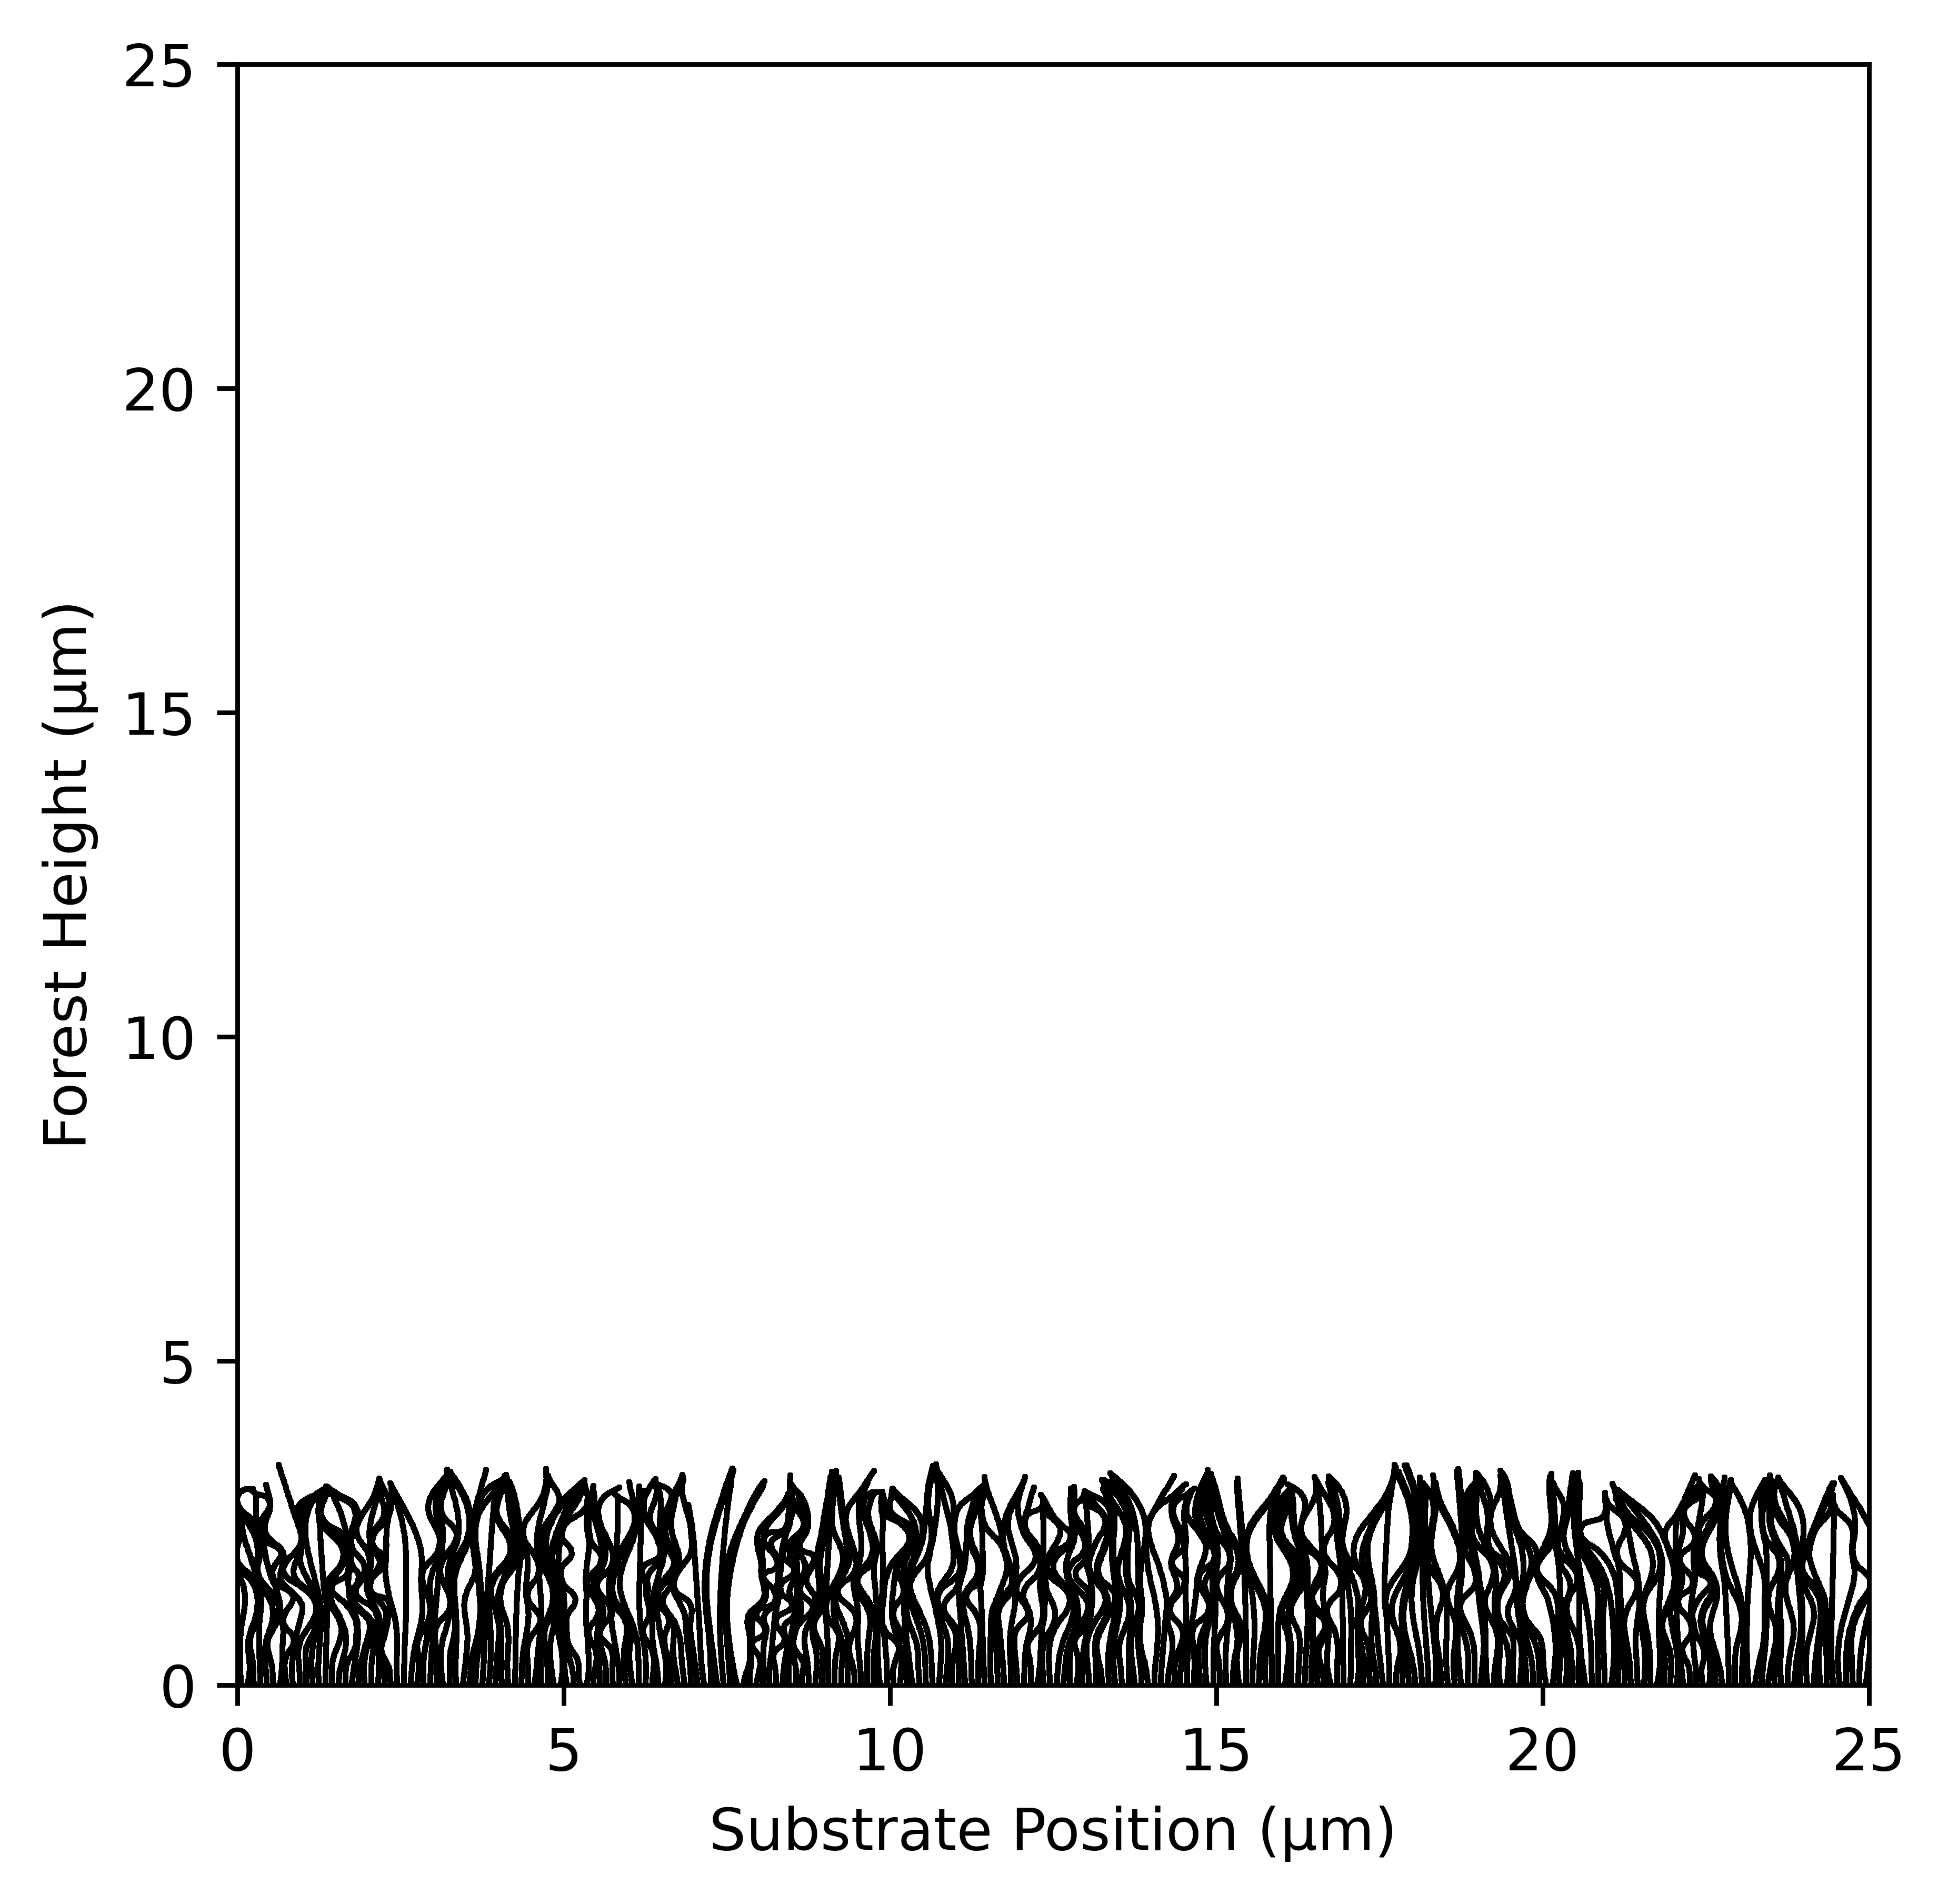

In [14]:
##############################################################################
#####################   BEGIN GROWTH STEPS  ##################################
##############################################################################
timer1=time.time()
for t in range(steps):
    closeNodes=closeNodesOLD; ## initializes nodes in contact to null 
    timer2=time.time()
    dx=np.zeros(element)
    dy=np.zeros(element)
    if t>0: #assigning properties to newly-grown elements
        e=((element-numberBeams)*np.ones(np.arange(0,numberBeams).size)+np.arange(0,numberBeams)).astype(int)
        e_e=np.arange(0,e.shape[0])
        L[e]=rate #should we track rate for each element at each time step?
        A[e]=A_0
        E[e]=E_0
        I[e]=np.transpose(I[e_e])
        ro[e]=np.transpose(ro[e_e])
        
    GDof=3*(nodeCount); # Global Degrees of Freedom

    closeNodes=FindCloseNodes_Range2a(nodeCoordinates[:nodeCount,:],nodeCount,numberBeams,ro[0],closeNodes)
    
    U=np.zeros((GDof,1)); force=np.zeros((GDof,1)) ##initializing variables
    i=0; ii=np.zeros((36,1)); iii=np.zeros((36,1)); j=0; jj=np.zeros((36,1)); jjj=np.zeros((36,1))
    vdwEquilForce=np.zeros((GDof, 1))
    
    dx[:element]=(nodeCoordinates[elementNodes[:nodeCount,1],0]-nodeCoordinates[elementNodes[:nodeCount,0],0])[:element]
    dy[:element]=(nodeCoordinates[elementNodes[:nodeCount,1],1]-nodeCoordinates[elementNodes[:nodeCount,0],1])[:element]
    
    #if PeriodicBoundary>0;         # For periodic boundary
    #conditions, if an element moves 6-1-20 Matt - can add later
    #    crossedl=find(xa>span/2);  # across a boundary, it shows up on the other side of 
    #    xa(crossedl)=xa(crossedl)-span; # the simulation domain 
    #    crossedr=find( xa <(-span/2 ) );
    #    xa(crossedr)=xa(crossedr)+span;
    #end

    Ldef=np.sqrt(np.square(dx)+np.square(dy))
    C=np.divide(dx,Ldef,out=np.zeros_like(Ldef),where=Ldef!=0)
    S=np.divide(dy,Ldef,out=np.zeros_like(Ldef),where=Ldef!=0)  #Computes Cosine and Sine for each element
    K=StiffnessPartial(E[:element],A[:element],I[:element],L[:element],C,S,g_mod,element,elementNodes[0:int(GDof),:],GDof,beamType,totalDOFs)
        
    ##### ATTRACIVE FORCES BY VAN DER WAALS ATTRACTION #############
    ################################################################
    
    vdwk=273 ####Should change this command line
    
    if closeNodes[0,:].all !=[0,0] and closeNodesOLD[0,:].all != [0,0]: #This isn't sufficient because closeNodes can get dropped
                
        closeNodesCombined=np.vstack((closeNodes,closeNodesOLD)) #This ensures that nodes were not accidentally missed by closeNodes call
        closeNodes=np.unique(closeNodesCombined,axis=0) #Updated list of closeNodes for time t
            
        if (closeNodes[0,:]==[0,0]).all(): #this is formatting for below
            closeNodes=np.delete(closeNodes,0,0);
            
        droppedNodesAdded=1
        print('droppedNodesAdded = '+str(droppedNodesAdded))
            
        ######################################################################
    
        # FINDING NEW CLOSENODES AND ESTABLISHING THEIR COORDINATES OF FIRST CONTACT         

        new_pairs=closeNodes #The first time close nodes are present
        vdwInfo=0

        ################ Computes the AA stiffness matrix  ###################
        sizeClose=closeNodes.shape[0]

        xa=nodeCoordinates[closeNodes[:,1],0]-nodeCoordinates[closeNodes[:,0],0]
        ya=nodeCoordinates[closeNodes[:,1],1]-nodeCoordinates[closeNodes[:,0],1]

        LL=np.sqrt(np.square(xa)+np.square(ya)); CC=np.divide(xa,LL); SS=np.divide(ya,LL)
        [AA,vdwk]=ConnectionStiffness_Partial(E,ro,CC,SS,sizeClose,closeNodes,GDof,beamType,totalDOFs)

        ######################################################################
        ######################################################################             

        K=K+AA # Adds vdW force to the global stiffness matrix
        
    ## Setting boundary conditions to solve for displacement #################

    ##########################################################################
    
    pdof=np.arange(numberBeams)
    
    #The lines below are boundary conditions that set the location for the
    #top node of the bottom element. U is displacement.
    U[GDof-3*numberBeams+3*pdof+0]=np.transpose(np.atleast_2d(np.multiply(rate,np.cos(ang))))
    U[GDof-3*numberBeams+3*pdof+1]=np.transpose(np.atleast_2d(np.multiply(rate,np.sin(ang))))
    U[GDof-3*numberBeams+3*pdof+2]=0
    
    alldof=np.arange((GDof-3*numberBeams),GDof) #% alldof is all fixed degrees of freedom
    prescribedDof=np.transpose(alldof) # Re-alinging alldof into a vector

    ##########################################################################
 
    activeDof=np.setdiff1d(np.arange(GDof),prescribedDof) #All free nodes in the system
    minus_K=-K[activeDof[0]:activeDof[-1]+1,prescribedDof[0]:prescribedDof[-1]+1]
    bc_U=csr_matrix(U[prescribedDof])
    
    timer3=time.time()    
    K_U=np.multiply(minus_K,bc_U)    
    displacements=spsolve(K[activeDof[0]:activeDof[-1]+1,activeDof[0]:activeDof[-1]+1],K_U)   
    print('Elapsed matrix solver time is '+str(time.time()-timer3)+' seconds.')
    
    U[activeDof[0]:activeDof[-1]+1]=np.transpose(np.atleast_2d(displacements)) #Defines the displacement of the free nodes
    i_i=np.arange(nodeCount)  #-numberBeams; ##Translates all nodes
    nodeCoordinates[i_i,0]=nodeCoordinates[i_i,0]+U[3*i_i].flatten()
    nodeCoordinates[i_i,1]=nodeCoordinates[i_i,1]+U[3*i_i+1].flatten()
    angle[i_i]=angle[i_i]+U[3*i_i+2].flatten()
    
    #if PeriodicBoundary>0; - add later
    #         crossedl=find(nodeCoordinates(:,1)<0);% moves across left boundary
    #         nodeCoordinates(crossedl,1)=nodeCoordinates(crossedl,1)+span;
    #         crossedr=find(nodeCoordinates(:,1)>span);
    #         nodeCoordinates(crossedr,1)=nodeCoordinates(crossedr,1)-span;
    #end

    currentCount=nodeCount

    ## Dividing the bottom-most elements ##
    for kk in range(currentCount,currentCount+numberBeams):
        nodeCoordinates[kk,0]=nucleationSite[kk-currentCount,0]
        nodeCoordinates[kk,1]=nucleationSite[kk-currentCount,1]
        elementNodes[element,0]=element
        elementNodes[element,1]=nodeCount
        element+=1
        nodeCount+=1

    print('t='+str(t))
    print('Elapsed time is '+str(time.time()-timer2)+' seconds.')
    if (t+1)%100==0: #plots every 100 steps
        print('plot me')
        CNTPlotFast(fname,nodeCoordinates[:nodeCount],t,title) #for python, only send the written nodeCoordinates

time1=time.time()-timer1
print('Total Elapsed time is '+str(time.time()-timer1)+' seconds.')